# 5-Minute Craft Youtube Video Titles

Team members: Douglas Greaves, Julio Oliveira, Satoshi Taniguchi

Data Source: https://www.kaggle.com/shivamb/5minute-crafts-video-views-dataset

This notebook aims to explore characteristics and generate insights from video titles of the Youtube channel [5-Minute Crafts](https://www.youtube.com/channel/UC295-Dw_tDNtZXFeAPAW6Aw) 

In [1]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

pd.options.display.float_format = '{:.2f}'.format

## Exploring the Dataset

In [2]:
df = pd.read_csv('../data/external/5-Minute Crafts.csv')

The dataset consists of the video_id, title, and previously calculated metrics.

In [3]:
df.head()

,video_id,title,active_since_days,duration_seconds,total_views,num_chars,num_words,num_punctuation,num_words_uppercase,num_words_lowercase,num_stopwords,avg_word_len,contain_digits,startswith_digits,title_sentiment
0,v=lCePSP4lb-k,Wow! Let's go live! Epic decorations and DIYS,1,558,10825,45,8,3,1,4,1,5.62,0,0,0.13
1,v=G7O9iWWOtTY,EXTREME ROOM TRANSFORMATION || Cool Design Ide...,1,1020,184374,63,10,2,3,0,2,6.30,0,0,0.11
2,v=cd0u5IFxBdo,LATE SUMMER HACKS TO SAVE YOUR DAY,2,629,478170,34,7,0,7,0,2,4.86,0,0,-0.30
3,v=lWSXHFPqBfo,EVERY SMART PARENT KNOWS THESE USEFUL HACKS #s...,2,41,197359,51,8,1,7,1,1,6.38,0,0,0.26
4,v=qqPFeyd84Lg,SMART HACKS TO SAVE YOUR WEDDING DAY🤵‍👰‍💍🕊️,3,784,162025,43,7,0,7,0,2,6.14,0,0,0.21


Total number of rows and columns:

In [4]:
df.shape

(4904, 15)

Checking the video ids, we can confirm that all videos are unique.

In [5]:
len(df.video_id.unique())

4904

Although all videos ids are unique, a small amount of video titles repeats.

In [6]:
len(df.title.unique())

4892

The dataset does not have any null values

In [7]:
df.isnull().values.any()

False

Let's check some descriptive statistics about the videos:

* Although the channel is called 5-minutes, 96% of the videos have a duration higher than 6 minutes, and 75% more than 11 minutes.
* The channel has a video with over 280M views. 75% of the videos have more than 567K views.
* The mean number of words is 8 on the video title.
* The average word length is 5.46, wich is close to the average length of English words of 5.1 according to [WolframAlpha](https://www.wolframalpha.com/input/?i=average+english+word+length)
* 93% of their videos have a digit in the title

In [8]:
df[['duration_seconds', 'total_views', 'num_words','avg_word_len', 'contain_digits']].describe()

,duration_seconds,total_views,num_words,avg_word_len,contain_digits
count,4904.00,4904.00,4904.00,4904.00,4904.00
mean,930.06,4331058.66,8.20,5.46,0.93
std,720.27,9706409.31,2.51,0.66,0.26
min,27.00,4034.00,3.00,3.67,0.00
25%,697.00,567791.00,6.00,5.00,1.00
50%,866.00,1459397.00,8.00,5.38,1.00
75%,960.00,4298147.50,10.00,5.80,1.00
max,14880.00,283031109.00,20.00,10.00,1.00


In [9]:
df[df.duration_seconds > 360].shape[0] / df.shape[0]

0.9563621533442088

## Distribution

Evaluating the distribution of active days since, we can notice that the dataset does not provide exact dates for when the video was published. This happens possibly because of how Youtube shows on its page the time since the video was published.

The number of videos with 'active days since' less than 365 is tiny. Therefore, comparing those videos with older ones may be misleading. For this reason, we drop them from the dataset.

[Text(0.5, 0, 'Active days since'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Accumalated distribution of Active days since')]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


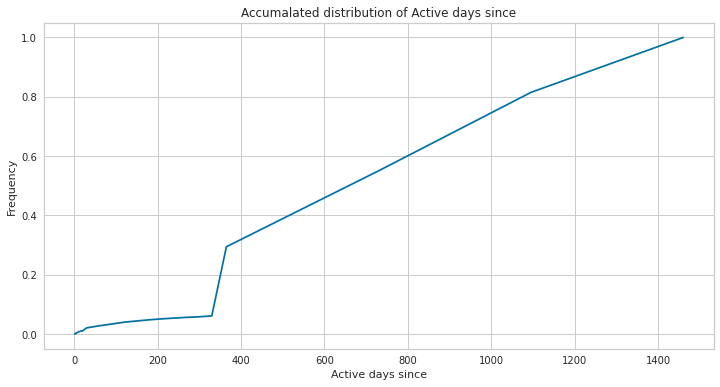

In [10]:
accumulated_percent = df.active_since_days.value_counts().sort_index() / df.active_since_days.count()
accumulated_percent = accumulated_percent.cumsum()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(accumulated_percent.index, accumulated_percent)
ax.set(xlabel="Active days since",
       ylabel="Frequency",
       title="Accumalated distribution of Active days since")

In [11]:
accumulated_percent

1      0.00
2      0.00
3      0.00
4      0.00
5      0.00
6      0.00
10     0.01
15     0.01
20     0.01
30     0.02
60     0.03
90     0.03
120    0.04
150    0.04
180    0.05
210    0.05
240    0.05
270    0.06
300    0.06
330    0.06
365    0.29
730    0.55
1095   0.81
1460   1.00
Name: active_since_days, dtype: float64

In [12]:
df = df[df.active_since_days >= 365]
df.shape

(4603, 15)

We first expected that older videos would have higher total views, however looking into the box plot of 'Total Views x 'Active Days Since', there is no clear distinction between those groups. This can be related to many reasons, one of them being the subscriber's growth rate of the channel over time.

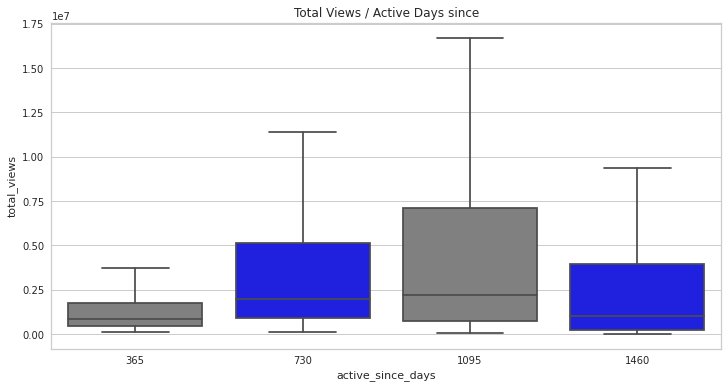

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(xlabel="Total Views",
       ylabel="Active Days Since",
       title="Total Views / Active Days since")

ax = sns.boxplot(x="active_since_days", y="total_views",
                 data=df, ax = ax, palette=['gray','blue'], showfliers=False)

As we noticed in the descriptive statistics of the dataset, the distribution of videos duration skewed to the right.

[Text(0.5, 0, 'Duration seconds'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Distribution of duration seconds')]

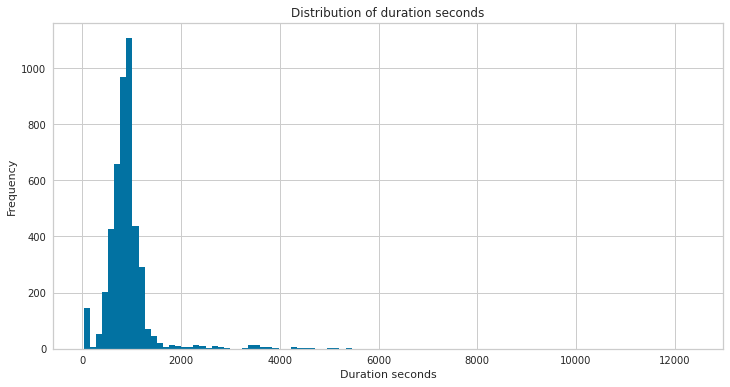

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(df.duration_seconds, bins=100)
ax.set(xlabel="Duration seconds",
       ylabel="Frequency",
       title="Distribution of duration seconds")

In [15]:
df.reset_index(inplace=True, drop=True)

## Feature Engineering

The features 'num_words_uppercase' and 'num_words_lowercase' are very similar to each other, for this reason we deleted them and created a feature called represint the percentual of uppercase words, given the total of words in the title.

In [16]:
df['perc_uppercase'] = df.num_words_uppercase / df.num_words
df.drop(['num_words_uppercase','num_words_lowercase'],axis=1, inplace=True)

In [17]:
original_features = df.columns

To evaluate the **relevance** of the words, we removed the stopwords and calculated the TF-IDF(term frequency weighted by inverse document frequency).

In [18]:
df['title'] = df.title.str.lower()

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
vectorizer = TfidfVectorizer(stop_words=stopwords, token_pattern=r"\b[^\d\W]+\b")


[nltk_data] Downloading package stopwords to /home/julio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
sdf = pd.DataFrame.sparse.from_spmatrix(vectorizer.fit_transform(df.title),
                         columns=vectorizer.get_feature_names_out())
df = df.join(sdf)

## Clustering

We noted before that the videos have different behavior for active_since_days, duration_seconds, and total_views. Therefore we used Kmeans to split the videos into a cluster based on these 3 variables.

### Normalization
The 3 features selected have very different magnitude. For this reason, before executing the Kmeans, we will use the Standard Scaler to normalize the data. 

In [20]:
X = df[['active_since_days', 'duration_seconds','total_views']].copy()
X = StandardScaler().fit_transform(X)

Using the elbow technique, we could notice that the best number of clusters is 9.

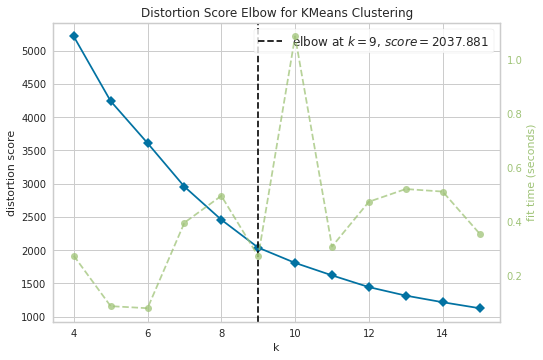

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(4,16))
elbow.fit(X)
elbow.show()

In [22]:
# Uncoment the lines below for retraining the model. 
# Attention, the cluster names steps below will need to be renamed. 

# kmeans = KMeans(elbow.elbow_value_)
# kmeans.fit(X)

# with open('../models/kmeans.pkl', 'wb') as file:
#     pickle.dump(kmeans, file)

with open('../models/kmeans.pkl', 'rb') as file:
    kmeans = pickle.load(file)

Looking into the size of each cluster, we can notice that some clusters are tiny. We will focus our study on the clusters with more than 100 videos.

In [23]:
df['cluster'] = kmeans.predict(X)
df.cluster.value_counts()

/tmp/ipykernel_14097/1531709052.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cluster'] = kmeans.predict(X)


7    1120
2    1109
0    1080
5     812
8     295
4     113
1      61
3       8
6       5
Name: cluster, dtype: int64

In [24]:
MIN_LEN = 100

clusters_len = df.cluster.value_counts().sort_index()

clusters_filter = {i for i,value in enumerate(clusters_len) if value > MIN_LEN}
clusters_filter

{0, 2, 4, 5, 7, 8}

In [25]:
filtered_clusters = df[df.cluster.isin(clusters_filter)].copy()

Now that we filtered the clusters, we can visualize them using the 3 features selected to understand what they represent.

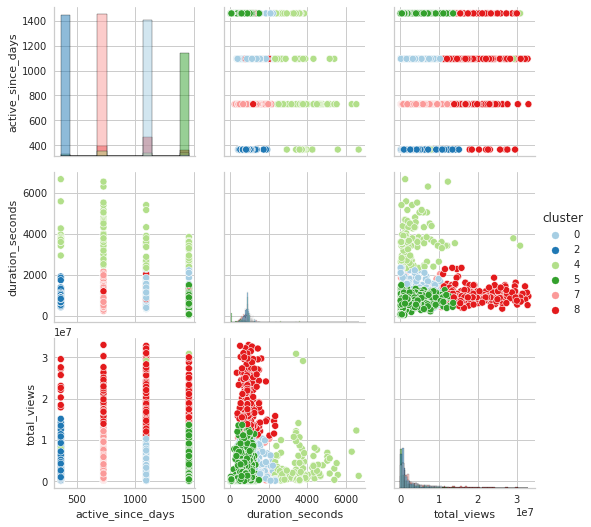

In [26]:
cols_to_plot = ['active_since_days', 'duration_seconds',
       'total_views', 'cluster']

g = sns.PairGrid(filtered_clusters[cols_to_plot], hue="cluster", palette="Paired")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

We named each cluster by looking into the characteristics in the chart above.

In [27]:
cluster_names = {
    0: '3 years ',
    2: '1 years',
    4: 'Long duration',
    7: '2 years',
    8: 'Top performers',
    5: '4 years'
}

filtered_clusters['cluster_name'] = df.cluster.map(cluster_names)

/tmp/ipykernel_14097/3347239372.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_clusters['cluster_name'] = df.cluster.map(cluster_names)


## Text Mining

For our first exploration of the title, we created the same chart above but evaluated the title features for each cluster.

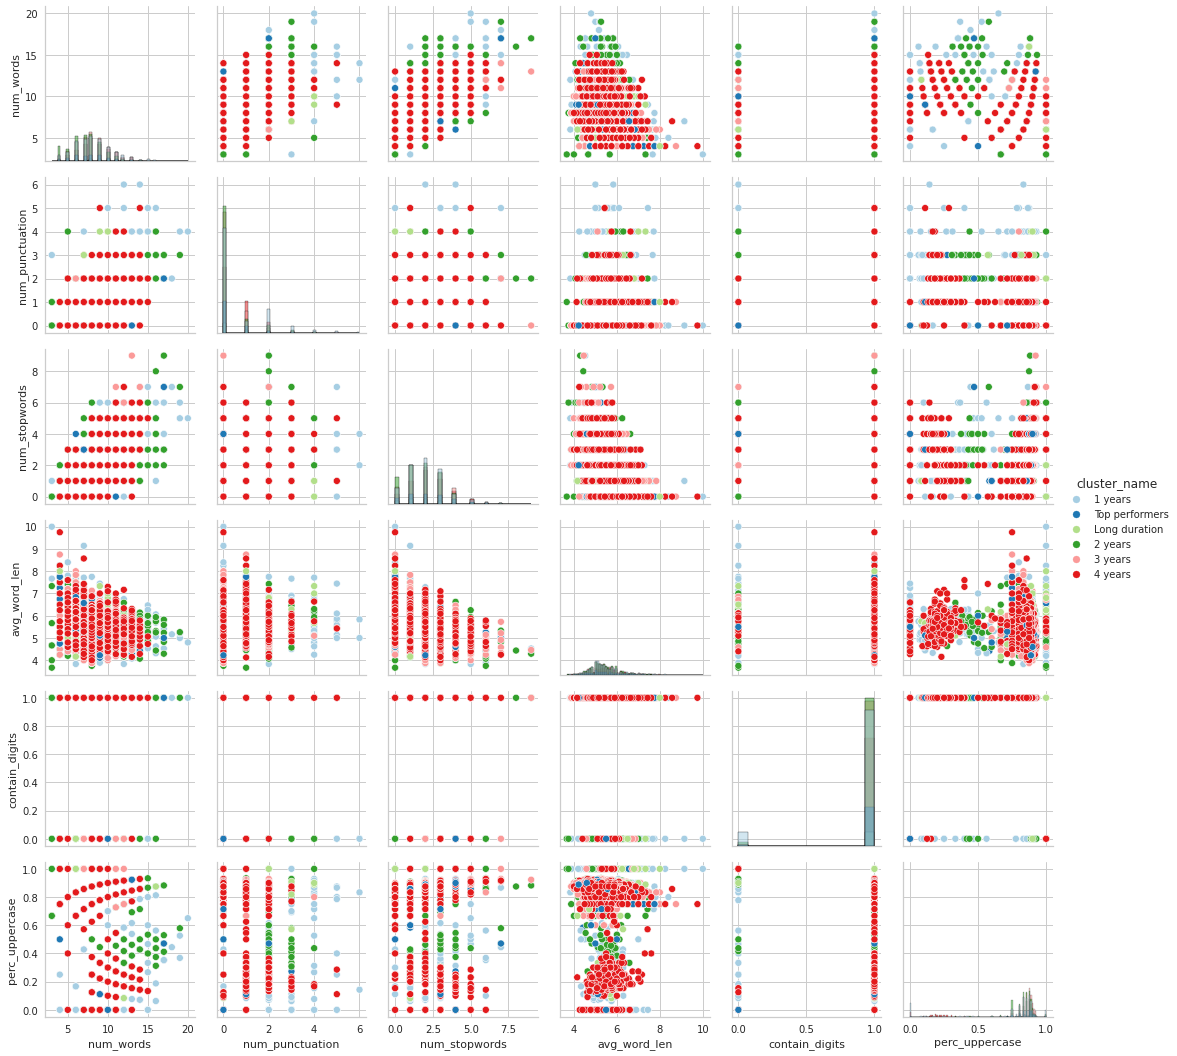

In [28]:
cols_to_plot = ['num_words', 'num_punctuation',
       'num_stopwords', 'avg_word_len', 'contain_digits',
       'perc_uppercase', 'cluster_name']

g = sns.PairGrid(filtered_clusters[cols_to_plot], hue="cluster_name", palette='Paired')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

Evaluating the chart above, we can notice some interesting points on how the youtube channel changed the title strategy over time.

### Insights
* 1 year videos: more words, more punctuation
* 3 years videos: more uppercase words
* 4 years digits: more titles containing digits
* Top performers: less punctuation

Let's explore these insights.

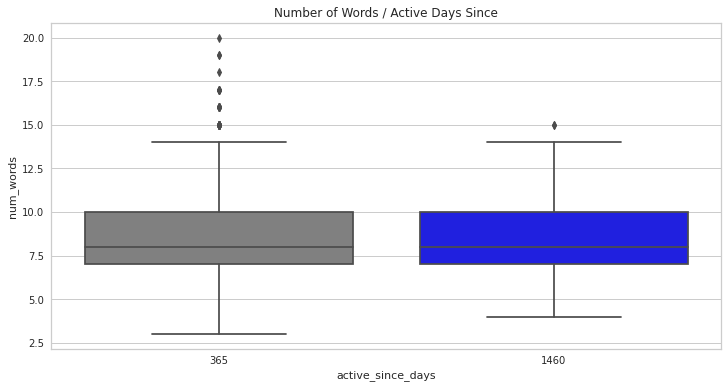

In [29]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(xlabel="Number of Words",
       ylabel="Active Days Since",
       title="Number of Words / Active Days Since")

data = df[df.active_since_days.isin({365, 1460})]
ax = sns.boxplot(x="active_since_days", y="num_words",
                 data=data, ax = ax, palette=['gray','blue'])

In [30]:
df.groupby('active_since_days')['contain_digits'].mean()

active_since_days
365    0.91
730    0.98
1095   0.99
1460   0.98
Name: contain_digits, dtype: float64

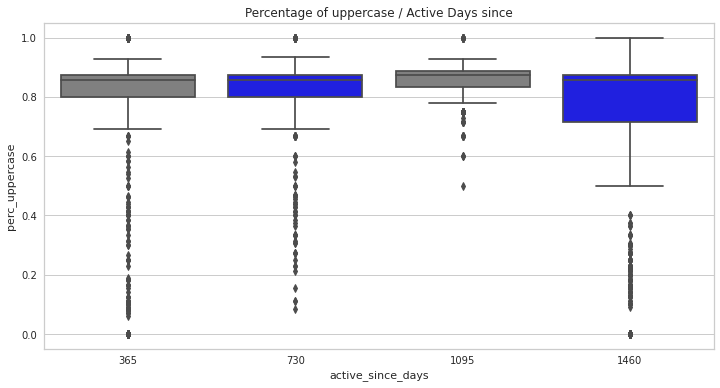

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(xlabel="Percentage of Uppercase",
       ylabel="Active Days Since",
       title="Percentage of uppercase / Active Days since")

data = df
ax = sns.boxplot(x="active_since_days", y="perc_uppercase",
                 data=data, ax = ax, palette=['gray','blue'])

In [32]:
cols_to_drop = list(original_features)+['cluster_name', 'cluster']
for c in filtered_clusters.cluster_name.unique():
    print(f'Evaluating most relevant words for each cluster: {c}')
    cluster_data = filtered_clusters[filtered_clusters.cluster_name == c].copy()
    cluster_data = cluster_data.drop(cols_to_drop, axis=1)
    print(cluster_data.mean().sort_values()[-10::])
    print('---------------\n')


Evaluating most relevant words for each cluster: 1 years
know     0.02
crazy    0.03
cool     0.03
home     0.03
try      0.03
life     0.03
tricks   0.03
diy      0.04
ideas    0.06
hacks    0.07
dtype: float64
---------------

Evaluating most relevant words for each cluster: Top performers
know     0.02
crazy    0.02
simple   0.02
ideas    0.02
cool     0.02
tricks   0.03
beauty   0.03
make     0.03
life     0.07
hacks    0.10
dtype: float64
---------------

Evaluating most relevant words for each cluster: Long duration
top           0.04
time          0.04
epic          0.04
crafts        0.04
beauty        0.05
compilation   0.08
life          0.09
best          0.10
live          0.11
hacks         0.11
dtype: float64
---------------

Evaluating most relevant words for each cluster: 2 years
easy     0.02
make     0.02
cool     0.02
know     0.03
tricks   0.03
beauty   0.03
crazy    0.04
ideas    0.04
life     0.05
hacks    0.10
dtype: float64
---------------

Evaluating most relev

### Insights
* Long duration has relevant words like: "Live", "Compilation"
* Comparing 4 years to 1 year: "craft" and "minute" used to the most relevant words in the title, what changed in the most recent videos.

### Are there words correlated to the video performance?

In [33]:
correlation = df.corr()
correlation.sort_values('total_views').total_views


l                   -0.08
num_chars           -0.04
num_punctuation     -0.04
ideas               -0.04
minute              -0.04
                     ... 
hacks                0.10
active_since_days    0.10
cluster              0.13
fortune              0.15
total_views          1.00
Name: total_views, Length: 1808, dtype: float64

Looking into the most positive correlated words, we notice that the R score is not high. However, the correlation between the tf-idf of the word "fortune" and total views is higher than "active_since_days." We will explore more the titles with this word below. 

In [34]:
df['has_fortune'] = df.fortune > 0
fortune_metrics = df.groupby(['active_since_days','has_fortune'])['total_views'].mean()
fortune_metrics


/tmp/ipykernel_14097/3054585213.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['has_fortune'] = df.fortune > 0


active_since_days  has_fortune
365                False          1890763.54
730                False          4572392.31
1095               False          6110776.16
                   True          57294977.00
1460               False          3929192.84
                   True          11243765.00
Name: total_views, dtype: float64

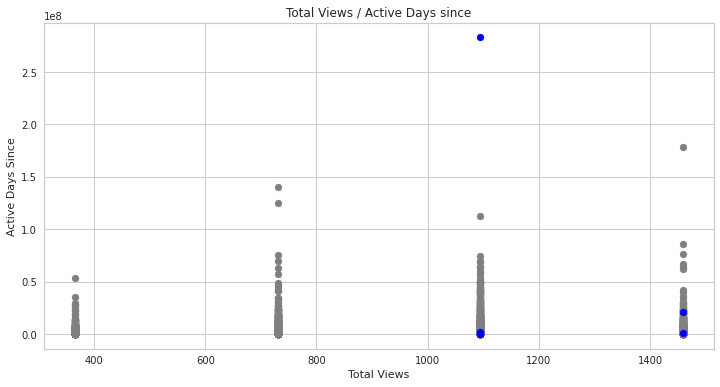

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(xlabel="Total Views",
       ylabel="Active Days Since",
       title="Total Views / Active Days since")


ax.scatter(df[df.has_fortune == False].active_since_days, df[df.has_fortune == False].total_views,c='gray', zorder=1)
ax.scatter(df[df.has_fortune == True].active_since_days, df[df.has_fortune == True].total_views,c='blue', zorder=10)

In the chart above, we evaluated the mean values of total_views of videos with the word fortune vs. the other videos in the same year. The videos with the word fortune are considerably higher than.

In [36]:
df[df.fortune > 0][['title','total_views']]

,title,total_views
2820,40 life hacks that will save you a fortune,439203
3086,30 cheap home repair hacks that will save you ...,1496512
3218,30 smart everyday tips that will save you a fo...,432835
3527,27 super easy diy clothing hacks that'll save ...,1075226
3549,42 holy grail hacks that will save you a fortune,283031109
4154,16 life hacks that'll help you save a fortune,1369195
4377,11 cool life tips that will save you a fortune,21118335


Looking into the metrics of videos with the word fortune as relevant, we could notice a pattern of videos with the sentence "that will save you a fortune". The mean of total views of those views is higher than other videos from the same year. In addition, the video with the highest number of views is part of the fortune group, which explains the high mean value of the group. However, the other videos from the group still show a higher number of views.

Possible improvements for this project:

* We don't know if some videos were promoted